# Task 1  

## General instructions

First, update the following text to have a link to your Homework 2 GitHub repository:

**UPDATE THIS LINK**
https://github.com/a-ramji/eds220-hwk-3

Add comments for all your code and commit as needed. Err on the side of commenting and commiting too much for now. Points will be deducted for insufficient comments.


## About the data
In this task you will use two datsets:

**First dataset**

The first dataset contains information about [spilling incidents in the state of New York](https://data.ny.gov/Energy-Environment/Spill-Incidents/u44d-k5fk). 
The data portal has plenty of information. 
You will find extra information and metadata for this datset in the 'NYSDEC_SpillIncidents_Overview.pdf' and 'NYSDEC_SpillIncidents_DataDictionary.pdf' documents available at the portal.

You can access this datset via its URL or download it as a csv. 
If you chose to access it via URL, it will take a while to load every time you import it. 

**Second dataset**

The second dataset is a [TIGER shapefile from the United States Census Bureau](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2022.html#list-tab-790442341). 
For this task you will need to **download the 2022 counties (and equivalent) TIGER shapefile**. 
You can check the [metadata for all the TIGER shapefiles here](https://www.census.gov/programs-surveys/geography/technical-documentation/complete-technical-documentation/tiger-geo-line.html). 



## File management
Make sure all your data files are inside a directory named 'data' inside your repository's directory (working directory).

## Datasets description
Read the metadata for both datsets and write a brief description about each once. Indicate the date sources and date of access.


**First dataset: Spilling incidents in New York Summary:**
"This dataset contains records of spills of petroleum and other hazardous materials. Under State law and regulations, spills that could pollute the lands or waters of the state must be reported by the spiller (and, in some cases, by anyone who has knowledge of the spill). "

Each spill record includes:
- Administrative information (DEC region and unique seven-digit spill number).
- Facility type.
- Spill date/time.
- Location.
- Contributing factor.
- Spill source and cause.
- Material(s) and material type spilled.
- Quantity spilled and recovered.
- Surface water bodies affected.
- Close date (cleanup activity finished and all paperwork completed). 

[source](https://data.ny.gov/Energy-Environment/Spill-Incidents/u44d-k5fk)(https://data.ny.gov/Energy-Environment/Spill-Incidents/u44d-k5fk)

Accessed November 6, 2023.


**second dataset:TIGER 2022 Counties and equivalent Summary:**

United States Census Bureau data TIGER/Line Shapefiles

"The TIGER/Line Shapefiles contain a standard geographic identifier (GEOID) for each entity that links to the GEOID in the data from censuses and surveys"

- the data do not contain demographic info, just geometries etc. 
- the data do not contain "sensitive" information
- county-level(and equivalent)/specified data 

"The TIGER/Line Shapefiles are extracts of selected geographic and cartographic information from the
Census Bureau's Master Address File (MAF)/Topologically Integrated Geographic Encoding and
Referencing (TIGER) System (MTS). The shapefiles include information for the fifty states, the District of Columbia, Puerto Rico, and the Island areas (American Samoa, the Commonwealth of the Northern
Mariana Islands, Guam, and the United States Virgin Islands). The shapefiles include polygon boundaries
of geographic areas and features, linear features including roads and hydrography, and point features." 

[Source](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2022.html#list-tab-790442341)
Accessed November 6, 2023.
(https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2022.html#list-tab-790442341)


## FINAL CODE

You will use the next cell at the end of the task. Leave it blank for now. 

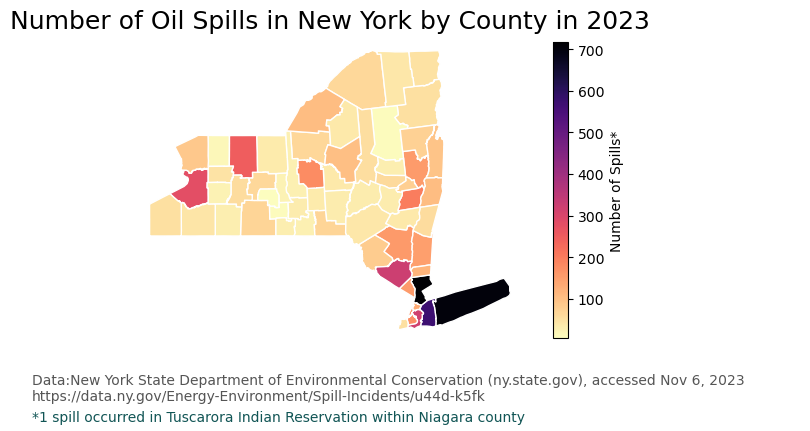

In [126]:
# importing libraries with standard abbreviations

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

# importing NY spills data
spills = pd.read_csv("data/Spill_Incidents_20231106.csv")

# importing counties data as a geoDataFrame
counties = gpd.read_file("data/tl_2022_us_county/tl_2022_us_county.shp")

# simplifying column names
spills.columns = spills.columns.str.lower().str.replace(' ','_')

# we want the spill date, so we'll use that column

# our spill_date and received_date columns are both type "object" rather than datetime64, 
# so we'll change this first using pd.to_datetime
spills.spill_date = pd.to_datetime(spills.spill_date)
spills.received_date = pd.to_datetime(spills.received_date)
spills.close_date = pd.to_datetime(spills.close_date)

# we only want data with petroleum spills, so we'll select those rows from material_family == Petroleum
# also selecting date values between january 1st 2023 and october 31st 2023 (inclusive)

petr_23 = spills[(spills['material_family'] == 'Petroleum') & (spills['spill_date'] >= '2023-01-01') & (spills['spill_date'] <= '2023-10-31')].copy()

# changing the datatype of spill_number to character/string to count unique values 
petr_23.spill_number = petr_23.spill_number.astype('str')

# extract number of spills by county as a pd.Series
n_spills = petr_23.groupby('county').nunique().spill_number.reset_index()

# renaming our dataframe n_spills to spills_per county, renaming spill_number column
spills_per_county = n_spills.rename(columns={'spill_number':'n_spills'})

# simplifying column names of counties dataset
counties.columns = counties.columns.str.lower()

# selecting counties in new york, found 36 as statefp code in the metadata
ny_counties = counties[ (counties.statefp == '36') ]

# merging our dataframes:
# we need to prepare our data a bit more before merging. 

# "St. Lawrence" county naming discrepancy between our datasets causes issues, so we'll rename it 
# first we need to select the first item in that tuple using [0] (the index where county name == St Lawrence)
st_lawrence_index = spills_per_county[spills_per_county.county=='St Lawrence'].index[0]

# using this index position, we can now rename it to St. Lawrence in spills_per_county
spills_per_county.at[st_lawrence_index, 'county'] = 'St. Lawrence'

# our county column labels don't match, so we need to rename this column in ny_counties
ny_counties = ny_counties.rename(columns={'name':'county'})

# we're ready to merge!

# renaming ny_counties as the merged dataframe:
ny_counties = pd.merge(ny_counties,
                 spills_per_county,
                 how='inner',
                 on='county')

# however, our T. Indian Reservation oil spill (count of 1) was lost, 
# so we need to add it back in as a count to Niagara county 

# first we need to find the index position and save it to use in the next step
niagara_index = ny_counties[ny_counties.county=='Niagara'].index[0]

# updating the dataframe to account for the oil spill in Tuscarora Indian Reservation
ny_counties.at[niagara_index, 'n_spills'] += 1

# we will make anote of this on our final plot.

# mapping the
fig, ax = plt.subplots()
#countries.plot(ax=ax)
ny_counties.plot(ax=ax,
                      column='n_spills', # labelling. my legend
                       cmap='magma_r', # updated color map, reversed
                       legend=True,
                       edgecolor="1",
                       legend_kwds={"shrink":.8,
                                    'label': "Number of Spills*"
                                    }
                       )

# adding title
ax.set_title('Number of Oil Spills in New York by County in 2023',  fontsize=18)
# removing axes
ax.axis('off')

# adding data source annotation
ax.annotate("Data:New York State Department of Environmental Conservation (ny.state.gov), accessed Nov 6, 2023 \nhttps://data.ny.gov/Energy-Environment/Spill-Incidents/u44d-k5fk", 
            xy=(0.05, .065), # position
            xycoords='figure fraction', 
            fontsize=10, 
            color='#555555')

# adding Tuscarora Inidan Reservation oil spill annotation
ax.annotate(text = "*1 spill occurred in Tuscarora Indian Reservation within Niagara county", 
            xy = (0.05, 0.02),
            xycoords='figure fraction',
            fontsize=10, 
            color='#115555')

plt.show()

<!-- write your description in this markdwon cell -->

## Import libraries

In [44]:
# import libraries here
# import numpy too

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

## Import data 
In the next cell:

- Import the NY spills data as a variable named `spills`. 
- Import the US counties shapefile as a variable named `counties`.


In [45]:
# importing NY spills data

spills = pd.read_csv("data/Spill_Incidents_20231106.csv")

# importing counties
counties = gpd.read_file("data/tl_2022_us_county/tl_2022_us_county.shp")

## Prepare spills data

This section refers to the `spills` dataframe. 
Check the outputs carefully, they will give you context about the next exercises.

### Exploration

In the next cells:

1. Check the dataframe's head
2. Simplify column names as needed
3. Check the data types of the columns
4. Check the unique values in the `material_family` column
5. Check the unique values in the `county` column

You can add any other cells of preliminary data exploration.

In [46]:
# 1. check dataframe's head
spills.head()

,Spill Number,Program Facility Name,Street 1,Street 2,Locality,County,ZIP Code,SWIS Code,DEC Region,Spill Date,Received Date,Contributing Factor,Waterbody,Source,Close Date,Material Name,Material Family,Quantity,Units,Recovered
0,107132,MH 864,RT 119/MILLWOOD RD,NaN,ELMSFORD,Westchester,NaN,6000,3,10/10/2001,10/10/2001,Unknown,NaN,Unknown,10/15/2001,unknown material,Other,10.0,Gallons,0.0
1,405586,BOWRY BAY,WATER POLL CONTROL,NaN,QUEENS,Queens,NaN,4101,2,08/21/2004,08/21/2004,Other,EAST RIVER,Unknown,09/17/2004,raw sewage,Other,0.0,Pounds,0.0
2,405586,BOWRY BAY,WATER POLL CONTROL,NaN,QUEENS,Queens,NaN,4101,2,08/21/2004,08/21/2004,Other,EAST RIVER,Unknown,09/17/2004,raw sewage,Other,0.0,NaN,0.0
3,204667,POLE 16091,GRACE AVE/BURKE AVE,NaN,BRONX,Bronx,NaN,301,2,08/02/2002,08/02/2002,Equipment Failure,NaN,Commercial/Industrial,10/28/2002,transformer oil,Petroleum,1.0,Gallons,0.0
4,210559,POLE ON,FERDALE LOMIS RD / RT 52,NaN,LIBERTY,Sullivan,NaN,5336,3,01/20/2003,01/20/2003,Traffic Accident,NaN,Commercial/Industrial,01/22/2003,transformer oil,Petroleum,6.0,Gallons,6.0


In [47]:
# 2. simplify column names as needed
spills.columns = spills.columns.str.lower().str.replace(' ','_')
spills.columns

Index(['spill_number', 'program_facility_name', 'street_1', 'street_2',
       'locality', 'county', 'zip_code', 'swis_code', 'dec_region',
       'spill_date', 'received_date', 'contributing_factor', 'waterbody',
       'source', 'close_date', 'material_name', 'material_family', 'quantity',
       'units', 'recovered'],
      dtype='object')

In [48]:
# 3. check the data types of the columns
spills.dtypes

spill_number               int64
program_facility_name     object
street_1                  object
street_2                  object
locality                  object
county                    object
zip_code                  object
swis_code                  int64
dec_region                 int64
spill_date                object
received_date             object
contributing_factor       object
waterbody                 object
source                    object
close_date                object
material_name             object
material_family           object
quantity                 float64
units                     object
recovered                float64
dtype: object

In [49]:
# 4. checking unique values in material_family column

spills.material_family.unique()

array(['Other', 'Petroleum', 'Hazardous Material', 'Oxygenates'],
      dtype=object)

In [50]:
# 5. checking the unique values in the "county" column

spills.county.unique()

array(['Westchester', 'Queens', 'Bronx', 'Sullivan', 'Cortland',
       'New York', 'Ulster', 'Kings', 'Orange', 'Dutchess', 'Onondaga',
       'Saratoga', 'Cayuga', 'Oswego', 'Warren', 'Niagara', 'Rockland',
       'Nassau', 'Jefferson', 'Schenectady', 'Albany', 'Monroe',
       'St Lawrence', 'Richmond', 'Clinton', 'Lewis', 'Essex', 'Chenango',
       'Erie', 'Livingston', 'Wayne', 'Suffolk', 'Orleans', 'Ontario',
       'Genesee', 'Otsego', 'Tompkins', 'Madison', 'Chemung', 'Seneca',
       'Oneida', 'Broome', 'Hamilton', 'Washington', 'Schuyler',
       'Franklin', 'Columbia', 'Fulton', 'Herkimer', 'Schoharie',
       'Rensselaer', 'Montgomery', 'Putnam', 'Delaware',
       'New Jersey - Region 2', 'Steuben', 'Tioga', 'Chautauqua',
       'Cattaraugus', 'Wyoming', 'Yates', 'Greene',
       'Pennsylvania - Region 9', 'Allegany', 'New Jersey - Region 3 (N)',
       'Cattaraugus Indian Reservation', 'New Jersey - Region 3 (T)',
       'Canada - Region 6', 'Canada - Region 9',
       '

### Data selection

1. Select data about petroleum spills that took place between January 1st 2023, and October 31st (including both dates), 2023. Store it in a variable named `petr_23`. The data selection should occur in a single line. You may add cells if you needed.

In [51]:
# we want the spill date, so we'll use that column

# our spill_date and received_date columns are both type "object" rather than datetime64, 
# so we'll change this first using pd.to_datetime

spills.spill_date = pd.to_datetime(spills.spill_date)
spills.received_date = pd.to_datetime(spills.received_date)
spills.close_date = pd.to_datetime(spills.close_date)

# let's check if this step worked:

spills.dtypes
# it did!

spill_number                      int64
program_facility_name            object
street_1                         object
street_2                         object
locality                         object
county                           object
zip_code                         object
swis_code                         int64
dec_region                        int64
spill_date               datetime64[ns]
received_date            datetime64[ns]
contributing_factor              object
waterbody                        object
source                           object
close_date               datetime64[ns]
material_name                    object
material_family                  object
quantity                        float64
units                            object
recovered                       float64
dtype: object

In [52]:
# we only want data with petroleum spills, so we'll select those rows from material_family == Petroleum

petroleum_spills = spills[ (spills['material_family'] == 'Petroleum')]
# checking to see if this step worked
petroleum_spills.material_family.unique()
# it did!

array(['Petroleum'], dtype=object)

In [53]:
# using our subset, now selecting date values between january 1st 2023 and october 31st 2023 (inclusive)

test = spills[(spills['spill_date'] >= '2023-01-01') & (spills['spill_date'] <= '2023-10-31')]

# checking the output
test.head()
# seems to work!
test.spill_date.unique()

array(['2023-05-30T00:00:00.000000000', '2023-06-06T00:00:00.000000000',
       '2023-08-02T00:00:00.000000000', '2023-08-28T00:00:00.000000000',
       '2023-09-27T00:00:00.000000000', '2023-07-28T00:00:00.000000000',
       '2023-01-13T00:00:00.000000000', '2023-02-09T00:00:00.000000000',
       '2023-05-07T00:00:00.000000000', '2023-03-31T00:00:00.000000000',
       '2023-03-23T00:00:00.000000000', '2023-03-15T00:00:00.000000000',
       '2023-06-12T00:00:00.000000000', '2023-09-16T00:00:00.000000000',
       '2023-10-16T00:00:00.000000000', '2023-06-05T00:00:00.000000000',
       '2023-08-15T00:00:00.000000000', '2023-08-21T00:00:00.000000000',
       '2023-09-20T00:00:00.000000000', '2023-03-08T00:00:00.000000000',
       '2023-06-15T00:00:00.000000000', '2023-05-21T00:00:00.000000000',
       '2023-05-15T00:00:00.000000000', '2023-05-12T00:00:00.000000000',
       '2023-06-30T00:00:00.000000000', '2023-01-04T00:00:00.000000000',
       '2023-07-02T00:00:00.000000000', '2023-02-08

In [54]:
# one liner

petr_23 = spills[(spills['material_family'] == 'Petroleum') & (spills['spill_date'] >= '2023-01-01') & (spills['spill_date'] <= '2023-10-31')].copy()


# checking my output again
print(len(spills) - len(petr_23))
petr_23.head()

535141


,spill_number,program_facility_name,street_1,street_2,locality,county,zip_code,swis_code,dec_region,spill_date,received_date,contributing_factor,waterbody,source,close_date,material_name,material_family,quantity,units,recovered
220,2301892,*** TEST SPILL ***,*** TEST SPILL ***,NaN,*** TEST SPILL ***,Onondaga,00000,3415,7,2023-06-06,2023-06-06,Tank Test Failure,NaN,Unknown,2023-07-12,#2 fuel oil,Petroleum,0.0,Gallons,0.0
221,2301892,*** TEST SPILL ***,*** TEST SPILL ***,NaN,*** TEST SPILL ***,Onondaga,00000,3415,7,2023-06-06,2023-06-06,Tank Test Failure,NaN,Unknown,2023-07-12,"used oil (heating, on-site consumption)",Petroleum,0.0,NaN,0.0
222,2301892,*** TEST SPILL ***,*** TEST SPILL ***,NaN,*** TEST SPILL ***,Onondaga,00000,3415,7,2023-06-06,2023-06-06,Tank Test Failure,NaN,Unknown,2023-07-12,#2 fuel oil (on-site consumption),Petroleum,0.0,NaN,0.0
223,2301892,*** TEST SPILL ***,*** TEST SPILL ***,NaN,*** TEST SPILL ***,Onondaga,00000,3415,7,2023-06-06,2023-06-06,Tank Test Failure,NaN,Unknown,2023-07-12,Diesel (E-Gen),Petroleum,0.0,NaN,0.0
225,2301892,*** TEST SPILL ***,*** TEST SPILL ***,NaN,*** TEST SPILL ***,Onondaga,00000,3415,7,2023-06-06,2023-06-06,Tank Test Failure,NaN,Unknown,2023-07-12,waste oil/used oil,Petroleum,0.0,NaN,0.0


2. Verify that `petr_23` only has data for petroleum spills 

In [55]:
petr_23.material_family.unique()

array(['Petroleum'], dtype=object)

3. Verify that `petr_23` only has data for 2023. 
HINT: if you converted the `spill_date` column to datetime, you can use `petr_23.spill_date.dt.year.unique()`

In [56]:
# I transformed my date columns to be datetime data types so I'll use the code suggested above

petr_23.spill_date.dt.year.unique()

array([2023])

4. Verify that `petr_23` only has data from January to October. 

In [57]:
# using the same code as above, specifying month instead of year
petr_23.spill_date.dt.month.unique()

array([ 6,  8,  9,  7,  1,  2,  3, 10,  5,  4])

### Data aggregation

Create new dataframe named `spills_per_county` with the number of petroleum spills per county from January to October 2023 (i.e. use the `petr_23` dataframe).

The resulting `spills_per_county` dataframe must be as follows:

- Index: integer numbers starting from 0
- Column one: county names, column name = `county`
- Column two: number of petroleum spills per county in 2023, column name = `n_spills`

You may add cells if you needed.

In [58]:
petr_23.spill_number = petr_23.spill_number.astype('str')
petr_23.dtypes

spill_number                     object
program_facility_name            object
street_1                         object
street_2                         object
locality                         object
county                           object
zip_code                         object
swis_code                         int64
dec_region                        int64
spill_date               datetime64[ns]
received_date            datetime64[ns]
contributing_factor              object
waterbody                        object
source                           object
close_date               datetime64[ns]
material_name                    object
material_family                  object
quantity                        float64
units                            object
recovered                       float64
dtype: object

In [59]:
len(petr_23)

7153

In [60]:
# extract number of spills by county as a pd.Series
n_spills = petr_23.groupby('county').nunique().spill_number.reset_index()
#.reset_index().county
n_spills
#type(n_spills)

,county,spill_number
0,Albany,198
1,Allegany,29
2,Bronx,133
3,Broome,69
4,Cattaraugus,43
...,...,...
59,Washington,94
60,Wayne,36
61,Westchester,717
62,Wyoming,24


In [61]:
# renaming our dataframe n_spills to spills_per county, renaming spill_number column
spills_per_county = n_spills.rename(columns={'spill_number':'n_spills'})
spills_per_county

,county,n_spills
0,Albany,198
1,Allegany,29
2,Bronx,133
3,Broome,69
4,Cattaraugus,43
...,...,...
59,Washington,94
60,Wayne,36
61,Westchester,717
62,Wyoming,24


In [62]:
# checking to see if we counted every row as a unique spill (which shouldn't be the case)
print(sum(n_spills.spill_number))

len(petr_23)

6966


7153

## Prepare counties data

This section refers to the `counties` geodataframe. 
Check the outputs carefully, they will give you context about the next exercises.

### Exploration

In the next cells:

1. Check the geo-dataframe's head
2. Simplify column names as needed
3. Check the data types of the columns
4. Check the geo-dataframe's CRS
5. Plot the geo-dataframe.

You can add any other cells of preliminary data exploration.

In [63]:
# 1. checking the head
counties.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477644346,10691216,+41.9158651,-096.7885168,"POLYGON ((-96.55515 41.91587, -96.55515 41.914..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680980770,61564427,+46.2946377,-123.4244583,"POLYGON ((-123.72755 46.26449, -123.72755 46.2..."
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016818946,29090018,+34.3592729,-104.3686961,"POLYGON ((-104.89337 34.08894, -104.89337 34.0..."
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,None,None,A,2169272978,22847034,+40.7835474,-096.6886584,"POLYGON ((-96.68493 40.52330, -96.69219 40.523..."
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645185,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27370 40.11840, -98.27374 40.122..."


In [64]:
# 2. simplifying column names
counties.columns = counties.columns.str.lower()
counties.columns

Index(['statefp', 'countyfp', 'countyns', 'geoid', 'name', 'namelsad', 'lsad',
       'classfp', 'mtfcc', 'csafp', 'cbsafp', 'metdivfp', 'funcstat', 'aland',
       'awater', 'intptlat', 'intptlon', 'geometry'],
      dtype='object')

In [65]:
# 3. checking data types of the columns
counties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3235 entries, 0 to 3234
Data columns (total 18 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   statefp   3235 non-null   object  
 1   countyfp  3235 non-null   object  
 2   countyns  3235 non-null   object  
 3   geoid     3235 non-null   object  
 4   name      3235 non-null   object  
 5   namelsad  3235 non-null   object  
 6   lsad      3235 non-null   object  
 7   classfp   3235 non-null   object  
 8   mtfcc     3235 non-null   object  
 9   csafp     0 non-null      object  
 10  cbsafp    0 non-null      object  
 11  metdivfp  0 non-null      object  
 12  funcstat  3235 non-null   object  
 13  aland     3235 non-null   int64   
 14  awater    3235 non-null   int64   
 15  intptlat  3235 non-null   object  
 16  intptlon  3235 non-null   object  
 17  geometry  3235 non-null   geometry
dtypes: geometry(1), int64(2), object(15)
memory usage: 455.0+ KB


In [66]:
# 4. checking the crs
counties.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

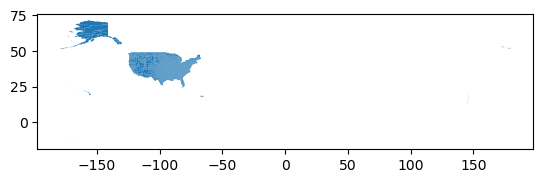

In [67]:
# 5.  plotting

counties.plot()

### Data selection

Select all the counties for the state of New York in a new variable `ny_counties` and plot them. HINT: to find which counties correspond to NY, look at the metadata.

Based on the head() view of our dataframe, I thought that STATEFP might be a good first step to subsetting our data. After checking out the [metadata](https://www2.census.gov/geo/pdfs/maps-data/data/tiger/tgrshp2022/TGRSHP2022_TechDoc_Ch3.pdf) from the website where we downloaded the data, I followed a link about ANSI codes. There I found info on New York NFPIS codes [here](https://www2.census.gov/geo/docs/reference/codes2020/cou/st36_ny_cou2020.txt), which showed that the STATEFP for New York is 36. 

<AxesSubplot:>

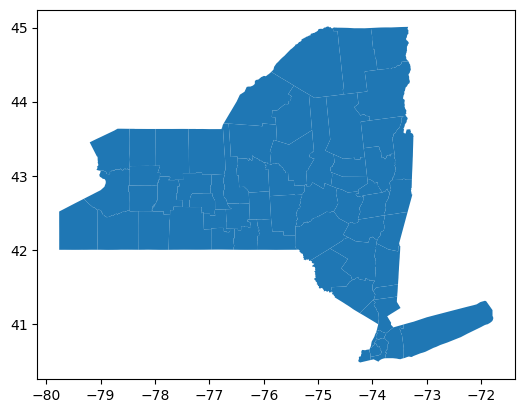

In [68]:
# the metadata shows a column called "county"
# selecting counties in new york
#
ny_counties = counties[ (counties.statefp == '36') ]
ny_counties.plot()

## Merging

The goal of this section is to create a single dataframe with the number of spills per county and the corresponding geometries for each county.

### Explore data

In the next cells:

1. Print the names of counties in `ny_counties`, without repetition.
2. Print the names of counties in `spills_per_county`, without repetition. (Do you notice anything?)
3. Use the [`numpy` function `setdiff1d()`](https://numpy.org/doc/stable/reference/generated/numpy.setdiff1d.html) to find the county names that are in `spills_per_county`, but not in `ny_counties`. HINT: pay attention to the example in the documentation.
4. Find the county names that are in `ny_counties`, but not in `spills_per_county`.
5. Check the number of spills in 'Tuscarora Indian Reservation'.


In [69]:
# 1. printing names of NY counties without repitition
county_names_ny = ny_counties.name.unique()
print(county_names_ny)

['Steuben' 'Saratoga' 'Allegany' 'Oswego' 'Ulster' 'St. Lawrence'
 'Schuyler' 'Essex' 'Suffolk' 'Hamilton' 'Dutchess' 'Otsego' 'Tompkins'
 'Albany' 'Cayuga' 'Greene' 'Herkimer' 'Warren' 'Jefferson' 'Clinton'
 'Nassau' 'Madison' 'Washington' 'Westchester' 'Lewis' 'Ontario'
 'Cortland' 'Richmond' 'Erie' 'Putnam' 'Montgomery' 'Sullivan' 'Orleans'
 'Oneida' 'Cattaraugus' 'Yates' 'Tioga' 'Monroe' 'Schoharie' 'Broome'
 'Rensselaer' 'Seneca' 'Queens' 'Genesee' 'Wayne' 'Niagara' 'Kings'
 'Chemung' 'Wyoming' 'New York' 'Columbia' 'Chautauqua' 'Franklin'
 'Onondaga' 'Chenango' 'Fulton' 'Rockland' 'Livingston' 'Delaware'
 'Orange' 'Schenectady' 'Bronx']


In [70]:
# 2. printing names of counties in spills_per_county without repetition
county_names_spills = spills_per_county.county.unique()
print(county_names_spills)
# I notice here that the list is sorted alphabetically, and there is a lot of overlap with the previous list of county names in New York

['Albany' 'Allegany' 'Bronx' 'Broome' 'Cattaraugus' 'Cayuga' 'Chautauqua'
 'Chemung' 'Chenango' 'Clinton' 'Columbia' 'Cortland' 'Delaware'
 'Dutchess' 'Erie' 'Essex' 'Franklin' 'Fulton' 'Genesee' 'Greene'
 'Hamilton' 'Herkimer' 'Jefferson' 'Kings' 'Lewis' 'Livingston' 'Madison'
 'Monroe' 'Montgomery' 'Nassau' 'New Jersey - Region 2' 'New York'
 'Niagara' 'Oneida' 'Onondaga' 'Ontario' 'Orange' 'Orleans' 'Oswego'
 'Otsego' 'Putnam' 'Queens' 'Rensselaer' 'Richmond' 'Rockland' 'Saratoga'
 'Schenectady' 'Schoharie' 'Schuyler' 'Seneca' 'St Lawrence' 'Steuben'
 'Suffolk' 'Sullivan' 'Tioga' 'Tompkins' 'Tuscarora Indian Reservation'
 'Ulster' 'Warren' 'Washington' 'Wayne' 'Westchester' 'Wyoming' 'Yates']


In [71]:
# 3. finding county names that are in spills_per_county, but not in ny_counties
# documentation example shows that it returns the values in array 1 that are not in array 2, not vice versa
np.setdiff1d(county_names_spills, county_names_ny, assume_unique=False)

array(['New Jersey - Region 2', 'St Lawrence',
       'Tuscarora Indian Reservation'], dtype=object)

In [72]:
# 4. finding the reverse
np.setdiff1d(county_names_ny, county_names_spills, assume_unique=False)
# note: the "." after "St" is causing this difference. 

array(['St. Lawrence'], dtype=object)

In [73]:
# 5. checking the number of spills per county in Tuscarora Indian Reservation
spills_per_county[(spills_per_county.county == 'Tuscarora Indian Reservation')]

,county,n_spills
56,Tuscarora Indian Reservation,1


### Data updates

In this section we will update 'St Lawrence' to 'St. Lawrence' in `spills_per_county` data frame.

In the next cells:
1. Check the row in `spills_per_county` that has 'St Lawrence'
2. Run the code and read the explanation in the comments
3. Run the code and read the explanation in the comments
4. Use the `st_lawrence_index` and `at` to update St Lawrence name in `spills_per_county` dataframe
5. Check the update was successfull

In [74]:
# 1. 
spills_per_county[(spills_per_county.county == "St Lawrence")]

,county,n_spills
50,St Lawrence,62


In [75]:
# 2. we can get the index of that single row like this, to access the actual row index...
spills_per_county[spills_per_county.county=='St Lawrence'].index

Int64Index([50], dtype='int64')

In [76]:
# 3. we need to select the first item in that tuple using [0]
st_lawrence_index = spills_per_county[spills_per_county.county=='St Lawrence'].index[0]
st_lawrence_index

50

In [77]:
# 4. updating the St Lawrence name in spills_per_county
spills_per_county.at[st_lawrence_index, 'county'] = 'St. Lawrence'

In [78]:
# 5.
# checking that the update was made:
spills_per_county.at[st_lawrence_index, 'county']

'St. Lawrence'

### Merge

In the following cells:
1. Use this cell to make any other updates needed for making an inner join of the `spills_per_county` and `ny_counties`. 
2. Over-write `ny_counties` as the  inner join of the `spills_per_county` and `ny_counties` dataframes.

From our previous exploration we know that Tuscarora Indian Reservation will not be in the join. Tuscarora Indian Reservation is located within Niagara county. 

3. Since the Tuscarora Indian Reservation does not appear in the `ny_counties` dataframe, add one spill to Niagara county. We will add a note about this in our final map. Add the cells you need to make this update **and** verify that the dataframe was updated.

In [79]:
# 1. preparing to inner join 
# checking that the crs match

ny_counties.crs
# we can see that the county column is called "name" instead of county
ny_counties.info()

# so we need to rename this column
ny_counties = ny_counties.rename(columns={'name':'county'})

# lets check that this update occurred
ny_counties.county
# nice!

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 62 entries, 46 to 3164
Data columns (total 18 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   statefp   62 non-null     object  
 1   countyfp  62 non-null     object  
 2   countyns  62 non-null     object  
 3   geoid     62 non-null     object  
 4   name      62 non-null     object  
 5   namelsad  62 non-null     object  
 6   lsad      62 non-null     object  
 7   classfp   62 non-null     object  
 8   mtfcc     62 non-null     object  
 9   csafp     0 non-null      object  
 10  cbsafp    0 non-null      object  
 11  metdivfp  0 non-null      object  
 12  funcstat  62 non-null     object  
 13  aland     62 non-null     int64   
 14  awater    62 non-null     int64   
 15  intptlat  62 non-null     object  
 16  intptlon  62 non-null     object  
 17  geometry  62 non-null     geometry
dtypes: geometry(1), int64(2), object(15)
memory usage: 9.2+ KB


46          Steuben
165        Saratoga
173        Allegany
203          Oswego
210          Ulster
           ...     
2936     Livingston
2963       Delaware
3157         Orange
3158    Schenectady
3164          Bronx
Name: county, Length: 62, dtype: object

In [80]:
# testing to see if we can merge the dataframes 
test2 = pd.merge(ny_counties,
                 spills_per_county,
                 how='inner',
                 on='county')
test2.head()
# it worked!

,statefp,countyfp,countyns,geoid,county,namelsad,lsad,classfp,mtfcc,csafp,cbsafp,metdivfp,funcstat,aland,awater,intptlat,intptlon,geometry,n_spills
0,36,101,00974148,36101,Steuben,Steuben County,06,H1,G4020,None,None,None,A,3601398422,35039875,+42.2667252,-077.3855253,"POLYGON ((-77.08327 42.00002, -77.09391 41.999...",68
1,36,091,00974143,36091,Saratoga,Saratoga County,06,H1,G4020,None,None,None,A,2097812305,87488004,+43.1061353,-073.8553872,"POLYGON ((-73.67891 42.91221, -73.67938 42.911...",155
2,36,003,00974100,36003,Allegany,Allegany County,06,H1,G4020,None,None,None,A,2666225086,12989848,+42.2478532,-078.0261531,"POLYGON ((-78.04342 42.51846, -78.04326 42.518...",29
3,36,075,00974136,36075,Oswego,Oswego County,06,H1,G4020,None,None,None,A,2464636023,933469962,+43.4614431,-076.2092618,"POLYGON ((-76.02509 43.70702, -76.02004 43.706...",65
4,36,111,00974153,36111,Ulster,Ulster County,06,H1,G4020,None,None,None,A,2911757764,94596810,+41.9472124,-074.2654582,"POLYGON ((-74.07480 42.09659, -74.06441 42.120...",158


In [81]:
# 2. renaming ny_counties as the merged dataframe:
ny_counties = pd.merge(ny_counties,
                 spills_per_county,
                 how='inner',
                 on='county')

In [82]:
# finding the index position for Niagara county 
print(ny_counties[ny_counties.county=='Niagara'].index[0])

# we know it is index position 45, so we'll use that in the next step. Let's save this output for now:
niagara_index = ny_counties[ny_counties.county=='Niagara'].index[0]

# here is the current value that we need to add one to
print(ny_counties.at[niagara_index, 'n_spills'])

45
88


In [83]:
# updating the dataframe to account for the oil spill in Tuscarora Indian Reservation
ny_counties.at[niagara_index, 'n_spills'] += 1

# checking to see if this worked
print(ny_counties.at[niagara_index, 'n_spills'])

89


## Map
Create a choropleth map of the number of petroleum spills per county in the state of New York in 2023. 
Your map should have (at least) the following updates:
- a legend indicating the number of spills
- an updated color map
- a title 
- no axis
- an annotation with the data source (New York State Department of Environmental Conservation), date of access HINT: check the graph we did for power plants, 
- an annotation indicating one spill occurred in Tuscarora Indian Reservation within Niagara county

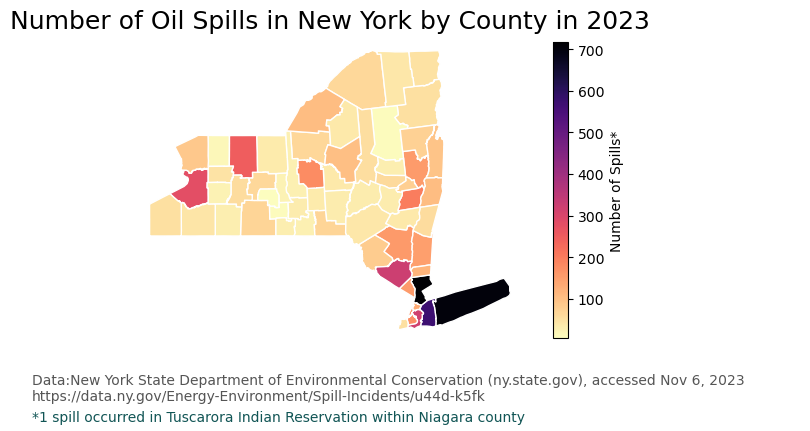

In [125]:
# mapping the
fig, ax = plt.subplots()
#countries.plot(ax=ax)
ny_counties.plot(ax=ax,
                      column='n_spills', # labelling. my legend
                       cmap='magma_r', # updated color map, reversed
                       legend=True,
                       edgecolor="1",
                       legend_kwds={"shrink":.8,
                                    'label': "Number of Spills*"
                                    }
                       )

# adding title
ax.set_title('Number of Oil Spills in New York by County in 2023',  fontsize=18)
# removing axes
ax.axis('off')

# adding data source annotation
ax.annotate("Data:New York State Department of Environmental Conservation (ny.state.gov), accessed Nov 6, 2023 \nhttps://data.ny.gov/Energy-Environment/Spill-Incidents/u44d-k5fk", 
            xy=(0.05, .065), # position
            xycoords='figure fraction', 
            fontsize=10, 
            color='#555555')

# adding Tuscarora Inidan Reservation oil spill annotation
ax.annotate(text = "*1 spill occurred in Tuscarora Indian Reservation within Niagara county", 
            xy = (0.05, 0.02),
            xycoords='figure fraction',
            fontsize=10, 
            color='#115555')

plt.show()

## Final code

Collect all the relevant code into the first blank cell of the notebook titled "FINAL CODE". This single cell will have the end-to-end workflow: from importing libraries and loading the data, to producing the graph. The *only* ouput of this cell should be the graph you produced in the previous exercise. For each line, add a single comment explaining what the code does.